# Alternative Classifier - XGBoost

In [75]:
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()[:-18])
from source.eda_utils import get_dataFrame_withShortCols, data_cleaner, preprocess_data
from source.ml_utils import calculate_non_correlated_features, print_results, plot_roc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import xgboost as xgb

In [76]:
# preprocessed data 
train_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('development_sample.csv')))
val_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('testing_sample.csv')))

c:\Users\mikol\PycharmProjects\Pre-selection Assignment\Pre-selection-Assignment\source\eda_utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_purpose_1_0'] = ((df_loan_purpose['loan_purpose_1.0'] == 1) & (df['Clasification of the vehicle'] == 0)).astype(int)
c:\Users\mikol\PycharmProjects\Pre-selection Assignment\Pre-selection-Assignment\source\eda_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_purpose_1_1'] = ((df_loan_purpose['loan_purpose_1.0'] == 1) & (df['Clasific

In [77]:
selected_features = calculate_non_correlated_features(X_train, 0.50)

In [78]:
X_train = train_data.drop(columns=['Default indicator', '_r_', 'Application date'])
y_train = train_data['Default indicator']

X_val = val_data.drop(columns=['Default indicator', '_r_', 'Application date'])
y_val = val_data['Default indicator']

selected_features = calculate_non_correlated_features(X_train, 0.50)
X_train = X_train[selected_features]
X_val = X_val[selected_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [79]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'eta': 0.05,  # Learning rate
    'max_depth': 5,  # Maximum depth of a tree
    'min_child_weight': 20,  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': 0.8,  # Subsample ratio of the training instance
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': 35,  # Set class weights
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'lambda': 0,  # L2 regularization term on weights
    'alpha': 0,  # L1 regularization term on weights
    'seed': 42,  # Random seed
    'max_delta_step': 1,
}


dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled)
xgb_model = xgb.train(params, dtrain)
y_pred_prob = xgb_model.predict(dval)
y_pred = (y_pred_prob > 0.5).astype(int)
print_results(y_val, y_pred)

Accuracy: 0.6184433164128595
Confusion Matrix:
[[2116 1311]
 [  42   77]]


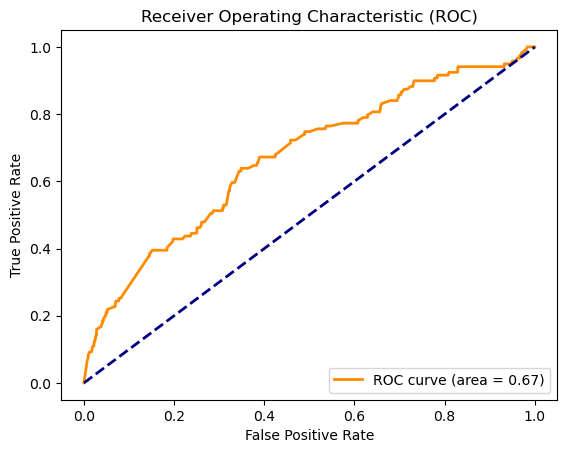

In [80]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plot_roc(fpr, tpr)